# Feature Detection is developed based on Iterative Shrinking

The implemented feature detections runs through a sequence of segmented fields (lowering / increasing the thresholds). It applies a basic object-based analysis and saves the analyzed cell properties as pandas DataFrame. This analysis is also needed in the "to-be-implemented" feature detection. Hence, we have two tasks
1. extract basic object-based analysis as module / function
2. implement wrapper to run exsting tools with Iris cubes

## Get the Iris Cube Again

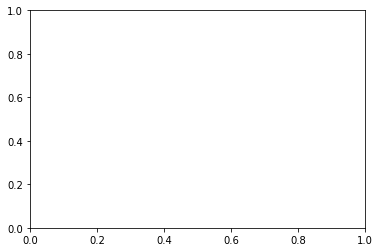

In [1]:
%matplotlib inline

import iris
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
from importlib import reload
import tobac
reload(tobac)
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


Download example data:

In [2]:
data_dir='Data'
data_file=os.path.join(data_dir,'data.nc')


Load Data from downloaded file:

In [3]:
OLR=iris.load_cube(data_file,'OLR')


In [4]:
OLRsub = OLR[:2]

## Get the Feature Function

In [5]:
# %load ../../tobac/feature_detection.py
import logging
import numpy as np
import pandas as pd

def feature_detection_multithreshold(field_in,
                                     dxy,
                                     threshold=None,
                                     min_num=0,
                                     target='maximum',
                                     position_threshold='center',
                                     sigma_threshold=0.5,
                                     n_erosion_threshold=0,
                                     n_min_threshold=0,
                                     min_distance=0,
                                     feature_number_start=1
                                     ):
    ''' Function to perform feature detection based on contiguous regions above/below a threshold
    Input:
    field_in:      iris.cube.Cube
                   2D field to perform the tracking on (needs to have coordinate 'time' along one of its dimensions)
    
    thresholds:    list of floats
                   threshold values used to select target regions to track
    dxy:           float
                   grid spacing of the input data (m)
    target:        str ('minimum' or 'maximum')
                   flag to determine if tracking is targetting minima or maxima in the data
    position_threshold: str('extreme', 'weighted_diff', 'weighted_abs' or 'center')
                      flag choosing method used for the position of the tracked feature
    sigma_threshold: float
                     standard deviation for intial filtering step
    n_erosion_threshold: int
                         number of pixel by which to erode the identified features
    n_min_threshold: int
                     minimum number of identified features

    min_distance:  float
                   minimum distance between detected features (m)
    Output:
    features:      pandas DataFrame 
                   detected features
    '''
    from skimage.measure import label
    from skimage.morphology import binary_erosion
    from scipy.ndimage.filters import gaussian_filter
    from tobac.utils import add_coordinates

    logging.debug('start feature detection based on thresholds')
    
    # create empty list to store features for all timesteps
    list_features_timesteps=[]

    # loop over timesteps for feature identification:
    data_time=field_in.slices_over('time')
    
    # if single threshold is put in as a single value, turn it into a list
    if type(threshold) in [int,float]:
        threshold=[threshold]    

    #----------------------------------------------------------------------
    # (1) LOOP OVER TIME
    #----------------------------------------------------------------------
    for i_time,data_i in enumerate(data_time):
        time_i=data_i.coord('time').units.num2date(data_i.coord('time').points[0])
        track_data = data_i.data
        
        track_data=gaussian_filter(track_data, sigma=sigma_threshold) #smooth data slightly to create rounded, continuous field
        # create empty lists to store regions and features for individual timestep
        regions=[]

        #----------------------------------------------------------------------
        # (2) LOOP OVER THRESHOLDS
        #---------------------------------------------------------------------- 
        list_features_thresholds = []
        for i_threshold,threshold_i in enumerate(threshold):

            # if looking for minima, set values above threshold to 0 and scale by data minimum:
            if target is 'maximum':
                mask=1*(track_data >= threshold_i)
    
            # if looking for minima, set values above threshold to 0 and scale by data minimum:
            elif target is 'minimum':            
                mask=1*(track_data <= threshold_i)  # only include values greater than threshold

            # erode selected regions by n pixels 
            if n_erosion_threshold>0:
                selem=np.ones((n_erosion_threshold,n_erosion_threshold))
                mask=binary_erosion(mask,selem).astype(np.int64)

            # detect individual regions, label  and count the number of pixels included:
            labels = label(mask, background=0)


            # start of the basic object-based analysis
            # =========================================
            values, count = np.unique(labels[:,:].ravel(), return_counts=True)
            values_counts=dict(zip(values, count))

            # Filter out regions that have less pixels than n_min_threshold
            values_counts={k:v for k, v in values_counts.items() if v>n_min_threshold}

            #check if not entire domain filled as one feature
            if 0 in values_counts:
                #Remove background counts:
                values_counts.pop(0)
                #create empty list to store individual features for this threshold
                list_features_threshold_i=[]
                

                #create empty dict to store regions for individual features for this threshold
                regions.append(dict())
                #create emptry list of features to remove from parent threshold value
                list_remove=[]
                
                #loop over individual regions:            
                for cur_idx,count in values_counts.items():
                    region=labels[:,:] == cur_idx
                    [a,b]= np.nonzero(region)                    
                    #write region for individual threshold and feature to dict
                    region_i=list(zip(a,b))
                    regions[i_threshold][cur_idx]=region_i
                    # Determine feature position for region by one of the following methods:
                    if position_threshold=='center':
                        # get position as geometrical centre of identified region:
                        hdim1_index=np.mean(a)
                        hdim2_index=np.mean(b)

                    elif position_threshold=='extreme':
                        #get positin as max/min position inside the identified region:
                        if target is 'maximum':
                            index=np.argmax(track_data[region])
                            hdim1_index=a[index]
                            hdim2_index=b[index]

                        if target is 'minimum':
                            index=np.argmin(track_data[region])
                            hdim1_index=a[index]
                            hdim2_index=b[index]

                    elif position_threshold=='weighted_diff':
                        # get position as centre of identified region, weighted by difference from the threshold:
                        weights=abs(track_data[region]-threshold_i)
                        if sum(weights)==0:
                            weights=None
                        hdim1_index=np.average(a,weights=weights)
                        hdim2_index=np.average(b,weights=weights)

                    elif position_threshold=='weighted_abs':
                        # get position as centre of identified region, weighted by absolute values if the field:
                        weights=abs(track_data[region])
                        if sum(weights)==0:
                            weights=None
                        hdim1_index=np.average(a,weights=weights)
                        hdim2_index=np.average(b,weights=weights)
                    else:
                        raise ValueError('position_threshold must be center,extreme,weighted_diff or weighted_abs')
                    
                    #create individual DataFrame row in tracky format for identified feature
                    list_features_threshold_i.append(pd.DataFrame(data={'frame': int(i_time),
                                                              'idx':cur_idx,
                                                              'hdim_1': hdim1_index,
                                                              'hdim_2':hdim2_index,
                                                              'num':count,
                                                              'threshold_value':threshold_i},
                                                        index=[i_time]))                
                    # For multiple threshold, record "parent" feature to be removed from Dataframe later
                    if i_threshold>0:
                        for idx,region in regions[i_threshold-1].items():
                            if (any(x in regions[i_threshold-1][idx] for x in region_i)):
                                list_remove.append(idx)

                    
                #check if list of features is not empty, then merge into DataFrame and append to list for different thresholds
                if any([x is not None for x in list_features_threshold_i]):
                    list_features_thresholds.append(pd.concat(list_features_threshold_i, ignore_index=True))
                else: 
                    list_features_thresholds.append(None)
            else:
                list_features_thresholds.append(None)
                regions.append(None)

                # If multiple thresholds, remove "parent" features from detection with previous threshold value
                    # remove duplicates drom list of features to remove from parent threshold:
            if i_threshold>0:

                list_remove=list(set(list_remove))                    
                # remove parent regions
                # remove from DataFrame of last threshold
                if list_features_thresholds[i_threshold-1] is not None:
                    list_features_thresholds[i_threshold-1]=list_features_thresholds[i_threshold-1][~list_features_thresholds[i_threshold-1]['idx'].isin(list_remove)]
                # remove from regions
                if regions[i_threshold-1] is not None:
                    for idx in list_remove:
                        regions[i_threshold-1].pop(idx)

            # finished feature detection for specific threshold value:
            logging.debug('Finished feature detection for threshold '+str(i_threshold) + ' : ' + str(threshold_i) )

        #check if list of features is not empty, then merge features from different threshold values 
        #into one DataFrame and append to list for individual timesteps:
        if any([x is not None for x in list_features_thresholds]):
            features_i_merged=pd.concat(list_features_thresholds, ignore_index=True)
            #Loop over DataFrame to remove features that are closer than distance_min to each other:
            if (min_distance > 0):
                features_i_merged=filter_min_distance(features_i_merged,dxy,min_distance)
            list_features_timesteps.append(features_i_merged)

        else:
            list_features_timesteps.append(None)
            
        logging.debug('Finished feature detection for ' + time_i.strftime('%Y-%m-%d_%H:%M:%S'))


    logging.debug('feature detection: merging DataFrames')
    # Check if features are detected and then concatenate features from different timesteps into one pandas DataFrame
    # If no features are detected raise error
    if any([x is not None for x in list_features_timesteps]):
        features=pd.concat(list_features_timesteps, ignore_index=True)   
    else:
        raise ValueError('No features detected')
    logging.debug('feature detection completed')
    features['feature']=features.index+feature_number_start
#    features_filtered = features.drop(features[features['num'] < min_num].index)
#    features_filtered.drop(columns=['idx','num','threshold_value'],inplace=True)
#    features_unfiltered=add_coordinates(features,field_in)
    features=add_coordinates(features,field_in)

    
    return features


######################################################################
######################################################################

def filter_min_distance(features,dxy,min_distance):
    from itertools import combinations

    remove_list_distance=[]
    #create list of tuples with all combinations of features at the timestep:
    indeces=combinations(features.index.values,2)
    #Loop over combinations to remove features that are closer together than min_distance and keep larger one (either higher threshold or larger area)
    for index_1,index_2 in indeces:
        if index_1 is not index_2:
            features.loc[index_1,'hdim_1']
            distance=dxy*np.sqrt((features.loc[index_1,'hdim_1']-features.loc[index_2,'hdim_1'])**2+(features.loc[index_1,'hdim_2']-features.loc[index_2,'hdim_2'])**2)
            if distance <= min_distance:
#                        logging.debug('distance<= min_distance: ' + str(distance))
                if features.loc[index_1,'threshold_value']>features.loc[index_2,'threshold_value']:
                    remove_list_distance.append(index_2)
                elif features.loc[index_1,'threshold_value']<features.loc[index_2,'threshold_value']:
                    remove_list_distance.append(index_1)
                elif features.loc[index_1,'threshold_value']==features.loc[index_2,'threshold_value']:
                    if features.loc[index_1,'num']>features.loc[index_2,'num']:
                        remove_list_distance.append(index_2)
                    elif features.loc[index_1,'num']<features.loc[index_2,'num']:
                        remove_list_distance.append(index_1)
                    elif features.loc[index_1,'num']==features.loc[index_2,'num']:
                        remove_list_distance.append(index_2)
    features=features[~features.index.isin(remove_list_distance)]
    return features


In [6]:
def basic_object_analysis(i_time, 
                          track_data,
                          threshold,
                          labels, 
                          features_list = [],
                          n_min_threshold = 0,
                          position_threshold = 'center',):
    
    

            # start of the basic object-based analysis
            # =========================================
            values, count = np.unique(labels[:,:].ravel(), return_counts = True)
            values_counts = dict(zip(values, count))

            # Filter out regions that have less pixels than n_min_threshold
            values_counts = {k:v for k, v in values_counts.items() if v > n_min_threshold}

            #check if not entire domain filled as one feature
            if 0 in values_counts:
                #Remove background counts:
                values_counts.pop(0)
                
                #create empty list to store individual features for this threshold
                features_list_i=[]
                                
                #loop over individual regions:            
                for cur_idx, count in values_counts.items():
                    region = ( labels[:,:] == cur_idx )
                    [a, b] = np.nonzero(region)                    

                    
                    # Determine feature position for region by one of the following methods:
                    if position_threshold == 'center':
                        # get position as geometrical centre of identified region:
                        hdim1_index = np.mean(a)
                        hdim2_index = np.mean(b)

                    elif position_threshold == 'extreme':
                        #get positin as max/min position inside the identified region:
                        if target is 'maximum':
                            index = np.argmax( track_data[region] )
                            hdim1_index = a[index]
                            hdim2_index = b[index]

                        if target is 'minimum':
                            index = np.argmin( track_data[region] )
                            hdim1_index = a[index]
                            hdim2_index = b[index]

                    elif position_threshold == 'weighted_diff':
                        
                        # get position as centre of identified region, weighted by difference from the threshold:
                        weights = abs(track_data[region] - threshold)
                        if sum(weights) == 0:
                            weights = None
                        hdim1_index = np.average(a, weights = weights)
                        hdim2_index = np.average(b, weights = weights)

                    elif position_threshold=='weighted_abs':
                        
                        # get position as centre of identified region, weighted by absolute values if the field:
                        weights = abs(track_data[region])
                        if sum(weights) == 0:
                            weights = None
                        hdim1_index = np.average(a,weights = weights)
                        hdim2_index = np.average(b,weights = weights)
                    else:
                        raise ValueError('position_threshold must be center,extreme,weighted_diff or weighted_abs')
                    
                    #create individual DataFrame row in tracky format for identified feature
                    features_list_i.append( pd.DataFrame(data = {'frame': int(i_time),
                                                              'idx': cur_idx,
                                                              'hdim_1': hdim1_index,
                                                              'hdim_2': hdim2_index,
                                                              'num': count,
                                                              'threshold_value': threshold},
                                                       index = [i_time]))     

                    
                #check if list of features is not empty, then merge into DataFrame and append to list for different thresholds
                if any([x is not None for x in features_list_i]):
                    features_list.append( pd.concat( features_list_i, ignore_index=True) )
                else: 
                    features_list.append(None)
            else:
                features_list.append(None)

            return features_list

In [7]:

def feature_detection_segmentation(  field_in,
                                     dxy,
                                     threshold = None,
                                     target = 'maximum',
                                     position_threshold = 'center',
                                     feature_number_start = 1,
                                     min_distance=0,
                                     **kwargs
                                     ):
    
    ''' Function to perform feature detection based on contiguous regions above/below a threshold
    Input:
    field_in:      iris.cube.Cube
                   2D field to perform the tracking on (needs to have coordinate 'time' along one of its dimensions)
    
    thresholds:    list of floats
                   threshold values used to select target regions to track
    dxy:           float
                   grid spacing of the input data (m)
    target:        str ('minimum' or 'maximum')
                   flag to determine if tracking is targetting minima or maxima in the data
    position_threshold: str('extreme', 'weighted_diff', 'weighted_abs' or 'center')
                      flag choosing method used for the position of the tracked feature
    sigma_threshold: float
                     standard deviation for intial filtering step
    n_erosion_threshold: int
                         number of pixel by which to erode the identified features
    n_min_threshold: int
                     minimum number of identified features

    min_distance:  float
                   minimum distance between detected features (m)
    Output:
    features:      pandas DataFrame 
                   detected features
    '''

    # an other keyword is used in the troposbox segmentation routines
    n_min_threshold = kwargs.get( 'min_size' , 0 )
    
    from tobac.utils import add_coordinates
    import tobac.troposbox.segmentation as seg

    logging.debug('start feature detection based on thresholds')
    
    # create empty list to store features for all timesteps
    list_features_timesteps=[]

    # loop over timesteps for feature identification:
    data_time = field_in.slices_over('time')
    
    #----------------------------------------------------------------------
    # (1) LOOP OVER TIME
    #----------------------------------------------------------------------
    for i_time, data_i in enumerate(data_time):
        time_i = data_i.coord('time').units.num2date(data_i.coord('time').points[0])
        track_data = data_i.data
        
        # if looking for minima, set values above threshold to 0 and scale by data minimum:
        if target is 'maximum':
            labels = seg.clustering(track_data, threshold, **kwargs)
            
        # if looking for minima, set values above threshold to 0 and scale by data minimum:
        elif target is 'minimum':            
            labels = seg.clustering(-track_data, -threshold, **kwargs)
        
            features_list =  basic_object_analysis(i_time, 
                                                   track_data,
                                                   threshold,
                                                   labels, 
                                                   n_min_threshold = n_min_threshold, 
                                                   position_threshold = position_threshold,)

            # finished feature detection for specific threshold value:
            logging.debug('Finished feature detection for threshold '+ str(threshold))

        #check if list of features is not empty, then merge features from different threshold values 
        #into one DataFrame and append to list for individual timesteps:
        if any([x is not None for x in features_list]):
            features_i_merged=pd.concat( features_list, ignore_index=True)
            #Loop over DataFrame to remove features that are closer than distance_min to each other:
            
            if (min_distance > 0):
                features_i_merged = filter_min_distance( features_i_merged, dxy,min_distance 
                                                       )
            list_features_timesteps.append(features_i_merged)

        else:
            list_features_timesteps.append(None)
            
        logging.debug('Finished feature detection for ' + time_i.strftime('%Y-%m-%d_%H:%M:%S'))


    logging.debug('feature detection: merging DataFrames')
    # Check if features are detected and then concatenate features from different timesteps into one pandas DataFrame
    # If no features are detected raise error
    if any([x is not None for x in list_features_timesteps]):
        features = pd.concat(list_features_timesteps, ignore_index=True)   
    else:
        raise ValueError('No features detected')
    logging.debug('feature detection completed')
    features['feature'] = features.index+feature_number_start
#    features_filtered = features.drop(features[features['num'] < min_num].index)
#    features_filtered.drop(columns=['idx','num','threshold_value'],inplace=True)
#    features_unfiltered=add_coordinates(features,field_in)
    features = add_coordinates(features,field_in)

    
    return features


######################################################################
######################################################################



## Do the Feature Detection "Offline"

In [8]:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=4
parameters_features['target']='minimum'
parameters_features['threshold']=220
parameters_features['threshold']=[250,225,200,175,150]




In [9]:
dxy,dt = tobac.get_spacings(OLR, grid_spacing = 4000)
#Features = feature_detection_multithreshold( OLRsub, dxy, **parameters_features)
Features = tobac.feature_detection_multithreshold( OLR, dxy, **parameters_features)
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,2,23.000000,173.000000,1,250,1,2013-06-19 21:32:23,2013-06-19 21:32:23,28.910470,-88.386986
1,0,6,34.000000,110.000000,1,250,2,2013-06-19 21:32:23,2013-06-19 21:32:23,29.330235,-90.791096
2,0,8,41.730609,65.554883,10,250,3,2013-06-19 21:32:23,2013-06-19 21:32:23,29.625239,-92.487142
3,0,9,42.433674,72.072979,4,250,4,2013-06-19 21:32:23,2013-06-19 21:32:23,29.652068,-92.238409
4,0,10,48.641181,164.496537,26,250,5,2013-06-19 21:32:23,2013-06-19 21:32:23,29.888949,-88.711482
5,0,11,48.000000,74.434266,2,250,6,2013-06-19 21:32:23,2013-06-19 21:32:23,29.864481,-92.148301
6,0,12,48.000000,143.000000,1,250,7,2013-06-19 21:32:23,2013-06-19 21:32:23,29.864481,-89.531800
7,0,13,49.000000,139.706587,2,250,8,2013-06-19 21:32:23,2013-06-19 21:32:23,29.902642,-89.657479
8,0,16,53.000000,115.000000,1,250,9,2013-06-19 21:32:23,2013-06-19 21:32:23,30.055284,-90.600294
9,0,17,60.000000,135.534993,2,250,10,2013-06-19 21:32:23,2013-06-19 21:32:23,30.322407,-89.816669


In [10]:
parameters_features={}
parameters_features['position_threshold'] = 'weighted_diff'
parameters_features['target'] = 'minimum'
parameters_features['threshold'] = 220


seg_kws = dict(          ctype = 4,
                         marker_field = 'dist',
                         filter_method = 'gauss',
                         cluster_masking = True,
                         exclude_border = True,
                         marker_method = 'iterative_shrinking',
                         siggauss = 0.5,
                         marker_shrinkage_Niter = 5,
                         marker_shrinkage_dmin = 0.2, 
                         min_size = 4)


parameters_features.update( seg_kws )

In [79]:

Features_seg = feature_detection_segmentation( OLRsub, dxy, **parameters_features)
Features_seg

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,1,67.523179,60.844935,1360,220,1,2013-06-19 21:32:23,2013-06-19 21:32:23,30.609495,-92.666876
1,0,2,32.456946,136.469882,226,220,2,2013-06-19 21:32:23,2013-06-19 21:32:23,29.271351,-89.780993
2,0,3,105.515586,141.341661,144,220,3,2013-06-19 21:32:23,2013-06-19 21:32:23,32.059303,-89.595083
3,0,4,59.505630,27.984380,130,220,4,2013-06-19 21:32:23,2013-06-19 21:32:23,30.303542,-93.920850
4,0,5,89.248506,10.979991,114,220,5,2013-06-19 21:32:23,2013-06-19 21:32:23,31.438544,-94.569746
5,0,6,55.650194,4.955002,82,220,6,2013-06-19 21:32:23,2013-06-19 21:32:23,30.156416,-94.799662
6,0,7,48.704308,90.382946,75,220,7,2013-06-19 21:32:23,2013-06-19 21:32:23,29.891358,-91.539692
7,0,8,88.148481,34.388113,53,220,8,2013-06-19 21:32:23,2013-06-19 21:32:23,31.396566,-93.676481
8,0,9,96.187469,156.966288,28,220,9,2013-06-19 21:32:23,2013-06-19 21:32:23,31.703338,-88.998840
9,0,10,37.786162,151.579737,20,220,10,2013-06-19 21:32:23,2013-06-19 21:32:23,29.474717,-89.204394


In [12]:
import tobac.feature_detection
Features_seg = tobac.feature_detection.feature_detection_segmentation( OLRsub, dxy, **parameters_features)
Features_seg

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,1,66.073803,63.888093,1120,220,1,2013-06-19 21:32:23,2013-06-19 21:32:23,30.554186,-92.550748
1,0,2,32.563280,135.644345,175,220,2,2013-06-19 21:32:23,2013-06-19 21:32:23,29.275409,-89.812496
2,0,3,105.492077,141.328692,151,220,3,2013-06-19 21:32:23,2013-06-19 21:32:23,32.058406,-89.595578
3,0,4,82.048320,53.880074,133,220,4,2013-06-19 21:32:23,2013-06-19 21:32:23,31.163781,-92.932659
4,0,5,89.195188,10.903469,128,220,5,2013-06-19 21:32:23,2013-06-19 21:32:23,31.436509,-94.572666
5,0,6,58.407947,26.897370,90,220,6,2013-06-19 21:32:23,2013-06-19 21:32:23,30.261654,-93.962331
6,0,7,55.631072,4.976559,84,220,7,2013-06-19 21:32:23,2013-06-19 21:32:23,30.155687,-94.798840
7,0,8,48.465640,90.265162,84,220,8,2013-06-19 21:32:23,2013-06-19 21:32:23,29.882250,-91.544187
8,0,9,48.264451,32.775444,69,220,9,2013-06-19 21:32:23,2013-06-19 21:32:23,29.874573,-93.738021
9,0,10,88.156578,34.323006,57,220,10,2013-06-19 21:32:23,2013-06-19 21:32:23,31.396875,-93.678966


## Plotting of an Example

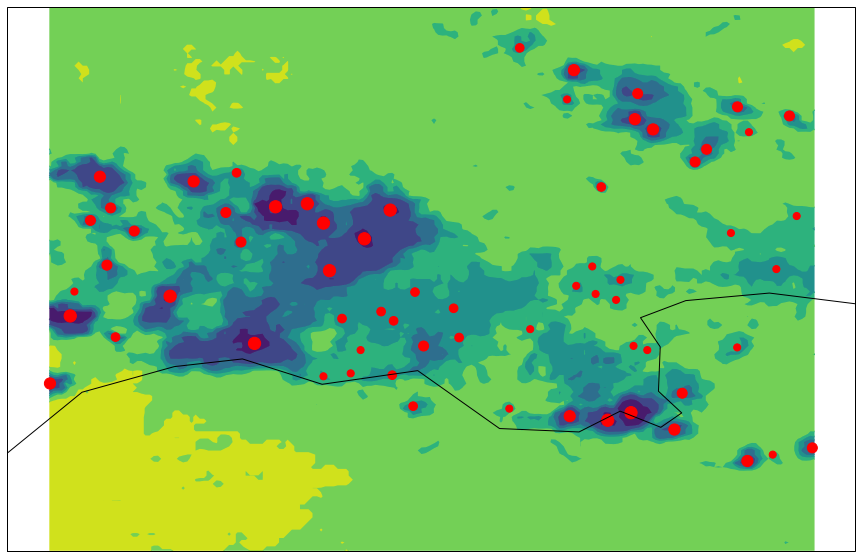

In [71]:
fig = plt.figure( figsize = (18,10))
# Draw the contour with 25 levels.
iplt.contourf(OLRsub[0], 5)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

fsub = Features[Features.frame == 0]
plt.scatter(fsub.longitude, fsub.latitude, c = 'r', s = 300 - fsub.threshold_value)

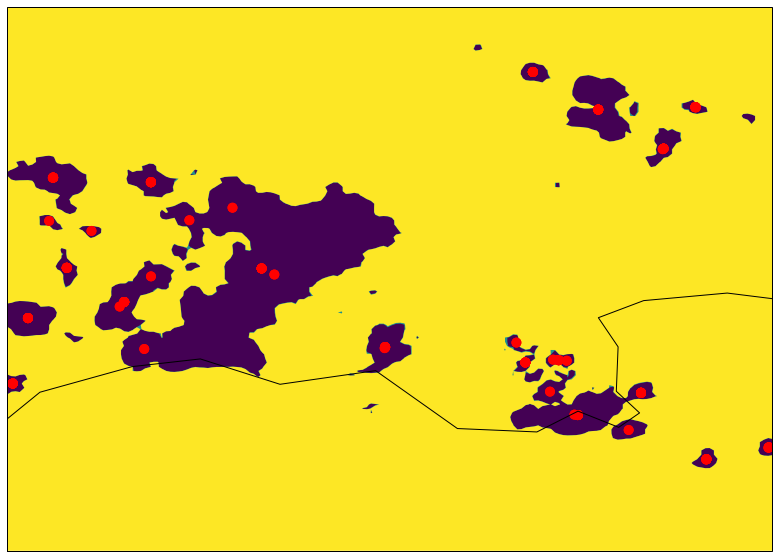

In [74]:
fig = plt.figure( figsize = (18,10))
# Draw the contour with 25 levels.
iplt.contourf(OLRsub[0], levels = [220,221], extend = 'both')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

fsub = Features_seg[Features_seg.frame == 0]
plt.scatter(fsub.longitude, fsub.latitude, c = 'r', s = 300 - fsub.threshold_value)

In [73]:
Features_seg[ Features_seg.frame == 0 ]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,1,67.523179,60.844935,1360,220,1,2013-06-19 21:32:23,2013-06-19 21:32:23,30.609495,-92.666876
1,0,2,32.456946,136.469882,226,220,2,2013-06-19 21:32:23,2013-06-19 21:32:23,29.271351,-89.780993
2,0,3,105.515586,141.341661,144,220,3,2013-06-19 21:32:23,2013-06-19 21:32:23,32.059303,-89.595083
3,0,4,59.505630,27.984380,130,220,4,2013-06-19 21:32:23,2013-06-19 21:32:23,30.303542,-93.920850
4,0,5,89.248506,10.979991,114,220,5,2013-06-19 21:32:23,2013-06-19 21:32:23,31.438544,-94.569746
5,0,6,55.650194,4.955002,82,220,6,2013-06-19 21:32:23,2013-06-19 21:32:23,30.156416,-94.799662
6,0,7,48.704308,90.382946,75,220,7,2013-06-19 21:32:23,2013-06-19 21:32:23,29.891358,-91.539692
7,0,8,88.148481,34.388113,53,220,8,2013-06-19 21:32:23,2013-06-19 21:32:23,31.396566,-93.676481
8,0,9,96.187469,156.966288,28,220,9,2013-06-19 21:32:23,2013-06-19 21:32:23,31.703338,-88.998840
9,0,10,37.786162,151.579737,20,220,10,2013-06-19 21:32:23,2013-06-19 21:32:23,29.474717,-89.204394


In [46]:
OLRsub.

<iris 'Cube' of OLR / (W m^-2) (time: 2; latitude: 131; longitude: 184)>